In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

**EDA**

In [2]:
input_df = pd.read_csv(r'website-traffic.csv')

In [3]:
input_df.head()

,DayOfWeek,MonthDay,Year,Visits
0,Monday,June 1,2009,27
1,Tuesday,June 2,2009,31
2,Wednesday,June 3,2009,38
3,Thursday,June 4,2009,38
4,Friday,June 5,2009,31


In [4]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DayOfWeek  214 non-null    object
 1   MonthDay   214 non-null    object
 2   Year       214 non-null    int64 
 3   Visits     214 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.8+ KB


In [6]:
input_df['date_of_visit'] = pd.to_datetime(input_df.MonthDay.str.cat(input_df.Year.astype(str), sep=' '))

<ipython-input-7-5188903f9ea2>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  deompose = seasonal_decompose(ts_visits.interpolate(),


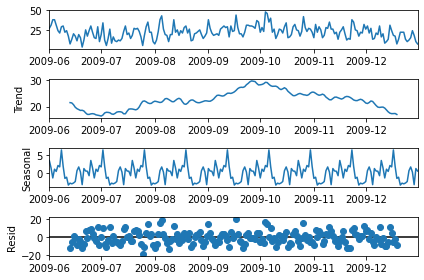

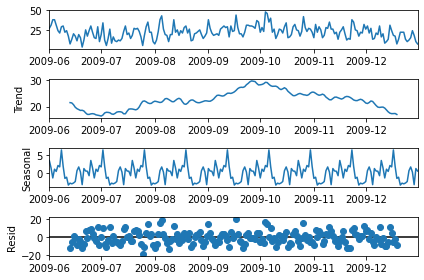

In [7]:
# extract visits as series from the dataframe
ts_visits = pd.Series(input_df.Visits.values,
                      index=pd.date_range(input_df.date_of_visit.min(),
                                          input_df.date_of_visit.max(),
                                          freq='D'))

deompose = seasonal_decompose(ts_visits.interpolate(),
                              freq=24)
deompose.plot()

No handles with labels found to put in legend.


   Visits  moving_average
0      27             NaN
1      31             NaN
2      38       32.000000
3      38       35.666667
4      31       35.666667
5      24       31.000000
6      21       25.333333
7      29       24.666667
8      30       26.666667
9      22       27.000000


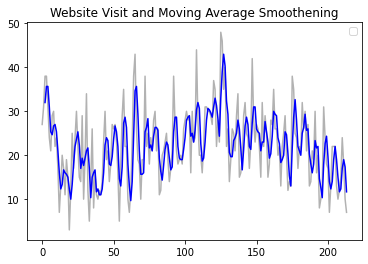

In [10]:
# moving average
input_df['moving_average'] = input_df['Visits'].rolling(window=3, center=False).mean()
print(input_df[['Visits','moving_average']].head(10))
plt.plot(input_df.Visits,'-',color='black',alpha=0.3)
plt.plot(input_df.moving_average,color='b')
plt.title('Website Visit and Moving Average Smoothening')
plt.legend()
plt.show()

No handles with labels found to put in legend.


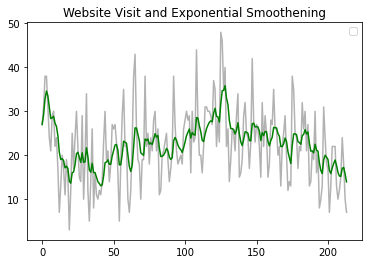

In [11]:
# exponential smoothing
input_df['ewma'] = input_df['Visits'].ewm(halflife=3, ignore_na=False, 
                                          min_periods=0, adjust=True).mean()
plt.plot(input_df.Visits,'-',color='black',alpha=0.3)
plt.plot(input_df.ewma,color='g')
plt.title('Website Visit and Exponential Smoothening')
plt.legend()
plt.show()